## Punto 2 - Primera parte
a) ¿Cómo se comportan las ventas mes a mes?

In [125]:
import pandas as pd
sales = pd.read_excel('Datos_segundo_punto_17Co2024_Grupo4.xlsx')
sales["Mes"] = sales["Fecha"].dt.month # alternativa: dt.month_name()
sales["DiaDeSemana"] = sales["Fecha"].dt.weekday
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Fecha        365 non-null    datetime64[ns]
 1   Ventas       365 non-null    float64       
 2   Mes          365 non-null    int32         
 3   DiaDeSemana  365 non-null    int32         
dtypes: datetime64[ns](1), float64(1), int32(2)
memory usage: 8.7 KB


In [126]:
sales.head()

,Fecha,Ventas,Mes,DiaDeSemana
0,2023-01-01,14864.134184,1,6
1,2023-01-02,16853.696596,1,0
2,2023-01-03,20726.932468,1,1
3,2023-01-04,19102.646430,1,2
4,2023-01-05,18955.206970,1,3


In [127]:
sales.tail()

,Fecha,Ventas,Mes,DiaDeSemana
360,2023-12-27,24173.447572,12,2
361,2023-12-28,22654.251064,12,3
362,2023-12-29,22822.365415,12,4
363,2023-12-30,19059.956125,12,5
364,2023-12-31,17446.387915,12,6


In [129]:
# ignorar esta celda
#sales_grouped_by_month = sales.groupby(by="Mes")["Ventas"].sum()
#sales_grouped_by_month.plot(kind='line', marker='o', linestyle=':')
#sales_per_weekday = sales.groupby(by="DiaDeSemana")["Ventas"].sum()
#sales_per_weekday.plot(kind='line', marker='o', linestyle=':')

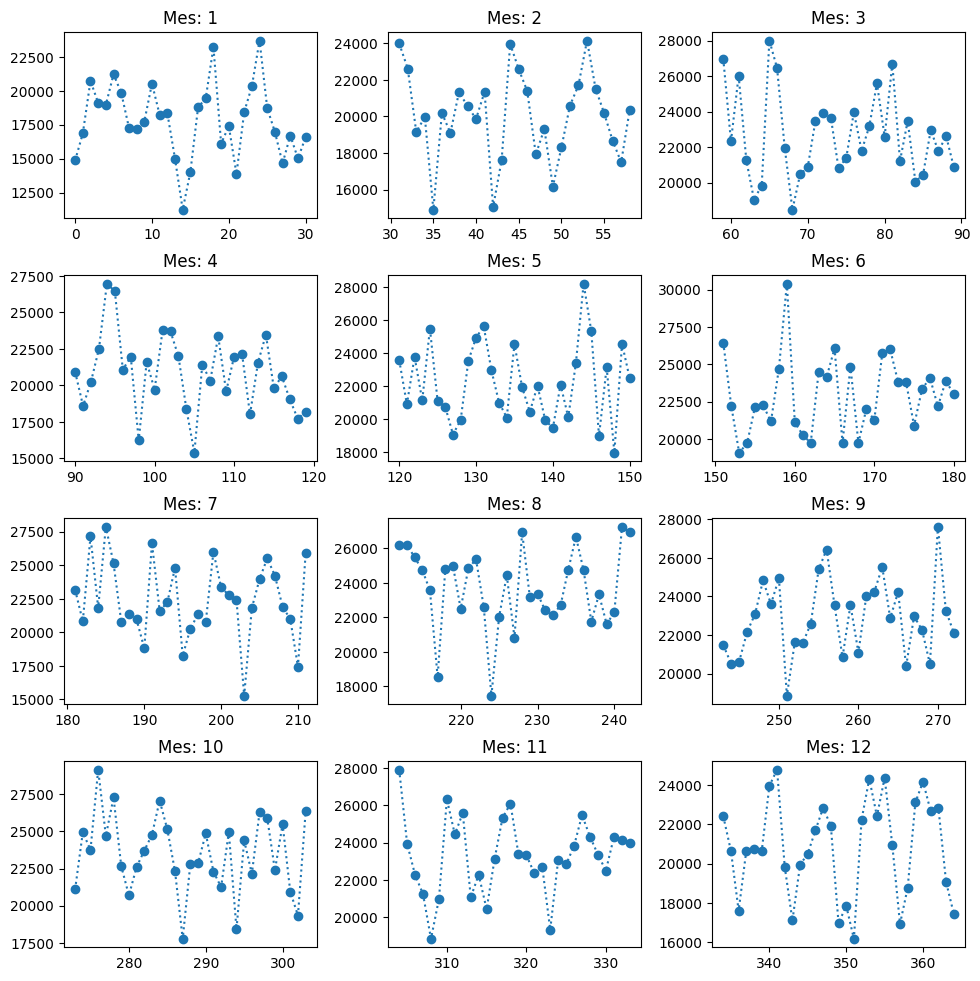

In [137]:
import matplotlib.pyplot as plt
sales_per_month = [sales[sales["Mes"] == (i+1)] for i in range(12)]

m = 4 
n = 3
figure, axis = plt.subplots(m,n, figsize=(10,10))
figure.tight_layout(pad = 2.0)
for i in range(m*n):
    row = i//n
    col = i%n
    if i < len(sales_per_month):
        axis[row][col].set_title(f"Mes: {i+1}")
        sales_per_month[i]["Ventas"].plot(kind='line', marker='o', linestyle=':', ax=axis[row][col])
    else: 
        axis[row][col].axis('off')
    

¿Cómo se comportan las ventas en cada día de la semana?

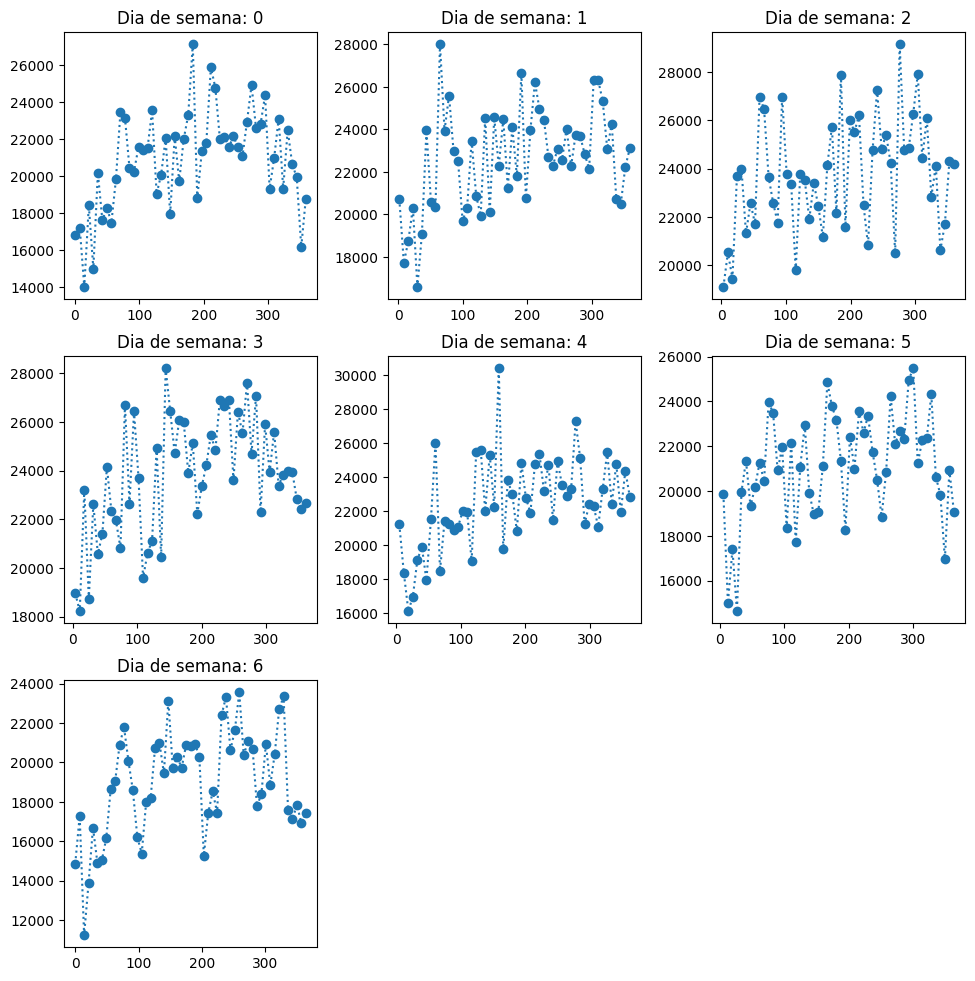

In [334]:
sales_per_weekday = [sales[sales["DiaDeSemana"] == i] for i in range(7)]

m = 3
n = 3
figure, axis = plt.subplots(m,n, figsize=(10,10))
figure.tight_layout(pad = 2.0)
for i in range(m*n):
    row = i//n
    col = i%n
    if i < len(sales_per_weekday):
        axis[row][col].set_title(f"Dia de semana: {i}")
        sales_per_weekday[i]["Ventas"].plot(kind='line', marker='o', linestyle=':', ax=axis[row][col])
    else:        
        axis[row,col].axis("off")

Donde dia 0 corresponde a Lunes, y 6 a Domingo.

## Punto 2 - Segunda Parte

In [333]:
# --- Turning off warnings for grid search
import warnings
warnings.filterwarnings("ignore")
# ----

import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'bandwidth': np.float64(2832.9045045045045), 'kernel': 'tophat'} : -48.786928174029974 None


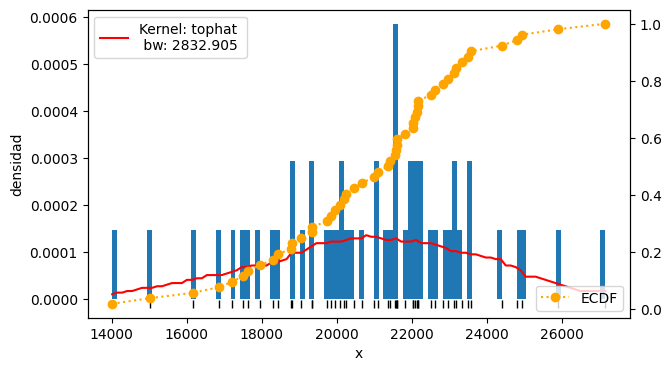

In [335]:
X = sales[sales["DiaDeSemana"] == 0]["Ventas"].values
ecdf = ECDF(X)

# .reshape(-1.1) => [[x1], [x2], ...] 
kde = KernelDensity(kernel='gaussian', bandwidth=1).fit(X.reshape(-1,1))


# Validación cruzada para identificar kernel y bandwidth
# ==============================================================================

param_grid = {
    'kernel': ['gaussian', 'epanechnikov', 'exponential', 'linear', 'cosine', 'tophat'],
    'bandwidth' : np.linspace(start=0.1, stop=10000, num=1000)
}

grid = GridSearchCV(
        estimator  = KernelDensity(),
        param_grid = param_grid,
        n_jobs     = -1,
        cv         = 10, 
        verbose    = 0
      )

# Se asigna el resultado a _ para que no se imprima por pantalla
_ = grid.fit(X = X.reshape(-1,1))


# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

modelo_kde_final = grid.best_estimator_


# Gráficos distribución de densidad modelo final
# ==============================================================================
X_grid = np.linspace(start=min(X), stop=max(X), num=100)
log_density_pred = modelo_kde_final.score_samples(X_grid.reshape(-1,1))
density_pred = np.exp(log_density_pred)
# 
fig, ax = plt.subplots(figsize=(7,4))
density, bins, patches = ax.hist(X, bins=100, density=True)

ax.plot(X_grid, density_pred, color = 'red', label=f'Kernel: {grid.best_params_["kernel"]} \n bw: {"{0:.3f}".format(grid.best_params_["bandwidth"])}')
ax.plot(X.flatten(), np.full_like(X.flatten(), -0.00001), '|k', markeredgewidth=1)
ax.set_xlabel('x')
ax.set_ylabel('densidad')
ax.legend(loc='upper left')
ax2 = ax.twinx()
ax2.plot(ecdf.x, ecdf.y, marker='o', linestyle=':', color='orange', label='ECDF')
ax2.legend(loc=4)


In [339]:
def get_estimations(X, ax):
# X = sales[sales["DiaDeSemana"] == 0]["Ventas"].values
    # assume X is 1-Dimensional
    ecdf = ECDF(X)    
    
    # Validación cruzada para identificar kernel y bandwidth
    # ==============================================================================
    
    param_grid = {
        'kernel': ['gaussian', 'epanechnikov', 'exponential', 'linear', 'cosine', 'tophat'],
        'bandwidth' : np.linspace(start=0.1, stop=10000, num=1000)
    }
    
    grid = GridSearchCV(
            estimator  = KernelDensity(),
            param_grid = param_grid,
            n_jobs     = -1,
            cv         = 10, 
            verbose    = 0
          )
    
    # Se asigna el resultado a _ para que no se imprima por pantalla
    _ = grid.fit(X = X.reshape(-1,1))
    # .reshape(-1.1) => [[x1], [x2], ...] 
    
    
    # Mejores hiperparámetros por validación cruzada
    # ==============================================================================
    # print("----------------------------------------")
    # print("Mejores hiperparámetros encontrados (cv)")
    # print("----------------------------------------")
    # print(grid.best_params_, ":", grid.best_score_, grid.scoring)
    
    modelo_kde_final = grid.best_estimator_
    
    
    # Gráficos distribución de densidad modelo final
    # ==============================================================================
    X_grid = np.linspace(start=min(X), stop=max(X), num=100)
    log_density_pred = modelo_kde_final.score_samples(X_grid.reshape(-1,1))
    density_pred = np.exp(log_density_pred)
    # 
    # fig, ax = plt.subplots(figsize=(7,4))
    density, bins, patches = ax.hist(X, bins=100, density=True)
    
    ax.plot(X_grid, density_pred, color = 'red', label=f'Kernel: {grid.best_params_["kernel"]} \n bw: {"{0:.3f}".format(grid.best_params_["bandwidth"])}')
    ax.plot(X.flatten(), np.full_like(X.flatten(), -0.00001), '|k', markeredgewidth=1)
    ax.set_xlabel('x')
    ax.set_ylabel('densidad')
    ax.legend(loc='upper left')
    ax2 = ax.twinx()
    ax2.plot(ecdf.x, ecdf.y, marker='o', linestyle=':', color='orange', label='ECDF')
    ax2.legend(loc=4)


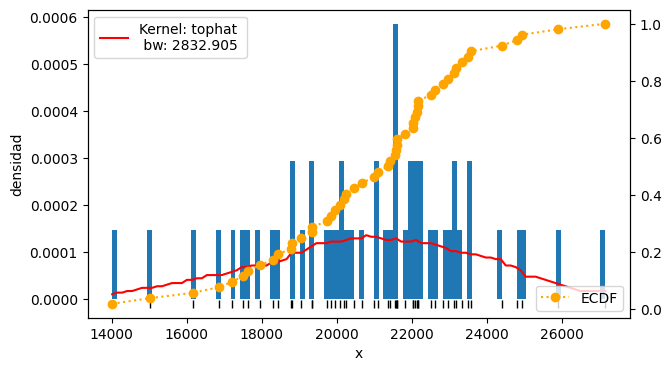

In [340]:
fig, ax = plt.subplots(figsize=(7,4))
get_estimations(X,ax)

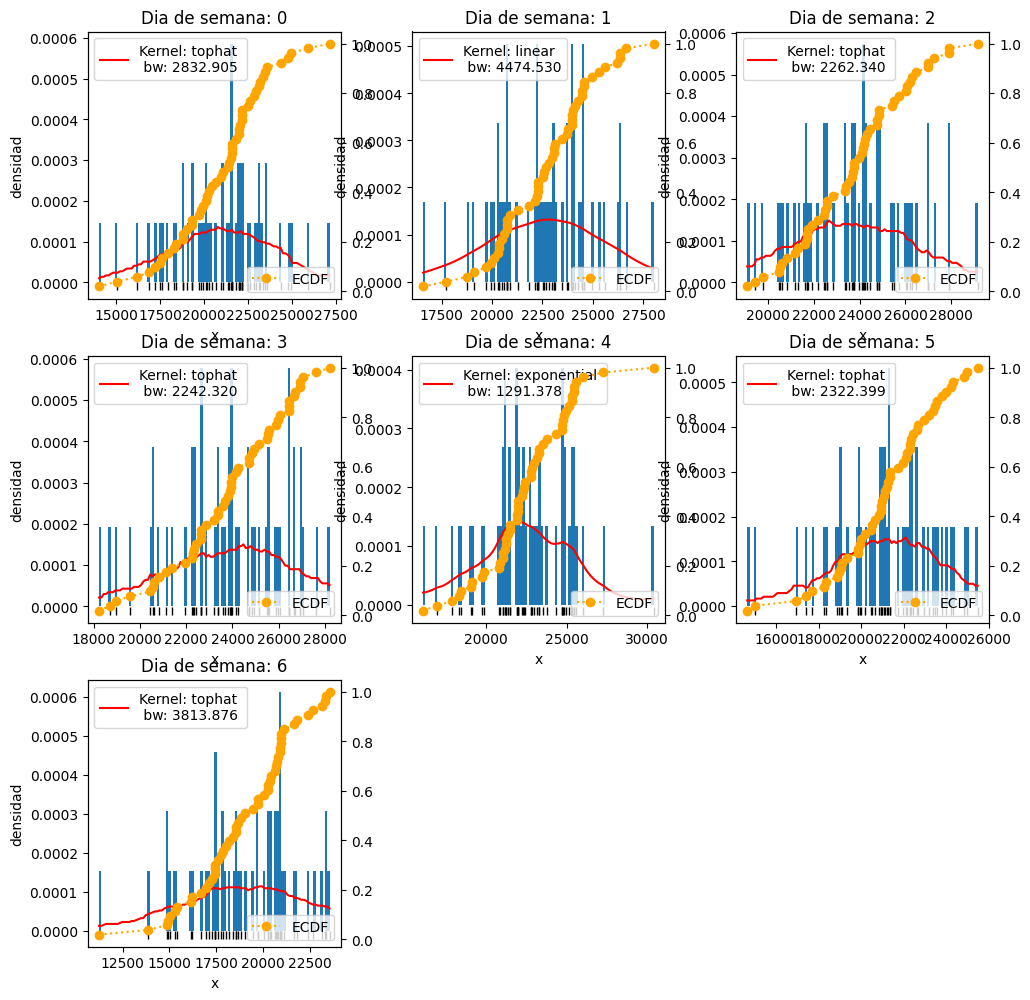

In [343]:
sales_per_weekday = [sales[sales["DiaDeSemana"] == i] for i in range(7)]

m = 3
n = 3
figure, axis = plt.subplots(m,n, figsize=(10,10))
figure.tight_layout(pad = 2.0)
for i in range(m*n):
    row = i//n
    col = i%n
    if i < len(sales_per_weekday):
        axis[row][col].set_title(f"Dia de semana: {i}")
        get_estimations(sales_per_weekday[i]["Ventas"].values,axis[row][col])
    else:        
        axis[row,col].axis("off")

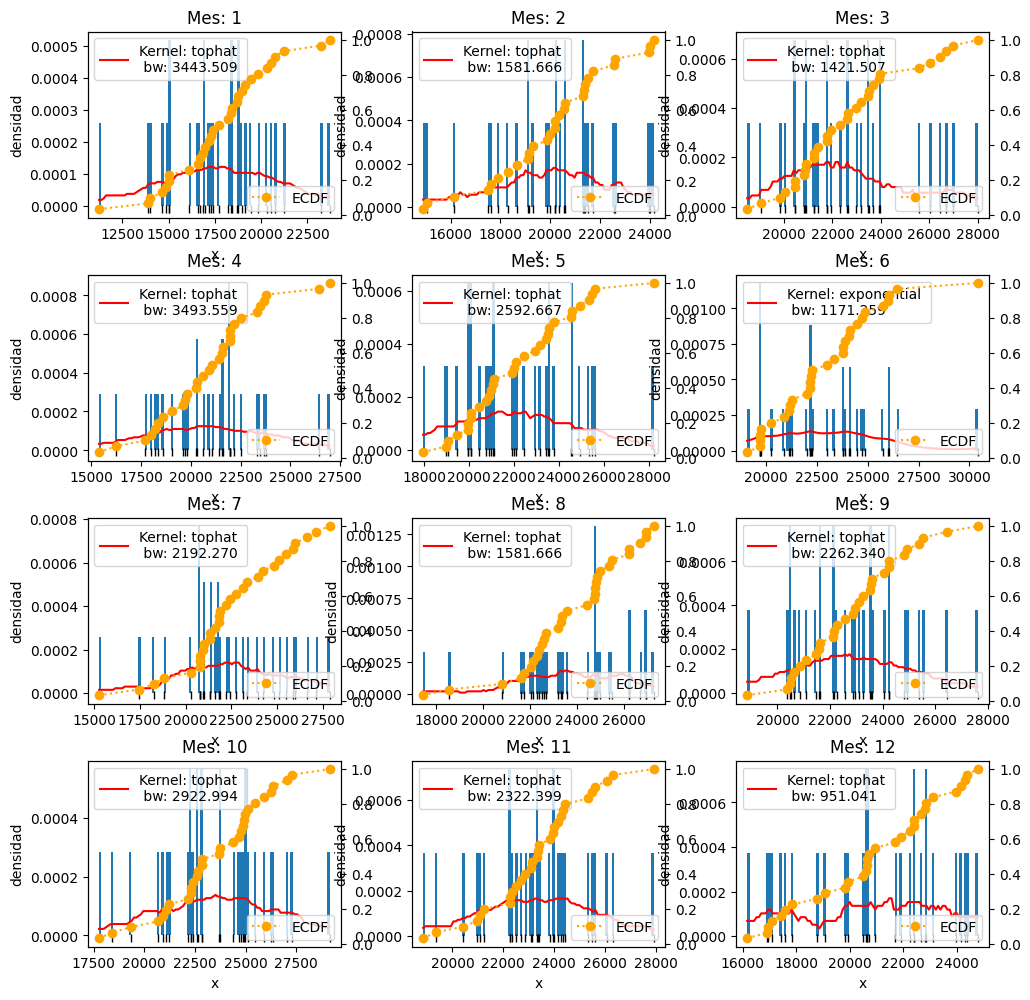

In [344]:
import matplotlib.pyplot as plt
sales_per_month = [sales[sales["Mes"] == (i+1)] for i in range(12)]

m = 4 
n = 3
figure, axis = plt.subplots(m,n, figsize=(10,10))
figure.tight_layout(pad = 2.0)
for i in range(m*n):
    row = i//n
    col = i%n
    if i < len(sales_per_month):
        axis[row][col].set_title(f"Mes: {i+1}")
        get_estimations(sales_per_month[i]["Ventas"].values,axis[row][col])
    else: 
        axis[row][col].axis('off')
    